In [ ]:
!pwd

In [1]:
import pandas as pd
import os
import shutil
import cv2
from multiprocessing import Pool
import time
import process_images_448_448
import process_images_128_128
import gc
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf
import PIL
from PIL import Image
import imageio
import logging as log
import tarfile
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
train_file_csv_df = pd.read_csv("train.csv")

In [ ]:
landmarks_greater_than_5_df = train_file_csv_df.landmark_id.value_counts().reset_index(name="count").query('count>5')
print("Sample of record in the train_file_csv_df dataframe : \n" + str(train_file_csv_df.head(1)))
print("Total number of images in the training set : " + str(train_file_csv_df['url'].count()))
print("Total number of unique landmark_ids in the training dataset : " + str(train_file_csv_df.landmark_id.value_counts()
                                                                                 .reset_index(name="count")["index"].count()))
print("Total number of landmarks with greater than 5 images in the dataset : " + str(landmarks_greater_than_5_df["index"].count()))

In [ ]:
filtered_train_greater_than_5_df = train_file_csv_df[train_file_csv_df.landmark_id.isin(landmarks_greater_than_5_df['index'])]
print("Total number of images for landmarks with image count of greater than 5 in the training set after filtering  : " + str(filtered_train_greater_than_5_df["id"].count()))
print(filtered_train_greater_than_5_df.head(1))
print(filtered_train_greater_than_5_df.iloc[1]['url'])

In [ ]:
imageIds_landmarkIds_dict = filtered_train_greater_than_5_df.set_index('id')['landmark_id'].to_dict()
len(imageIds_landmarkIds_dict)

In [ ]:
# del train_file_csv_df
gc.collect()

In [ ]:
landmarkIds_counts_df = pd.DataFrame(filtered_train_greater_than_5_df.landmark_id.value_counts())
landmarkIds_counts_df = landmarkIds_counts_df.rename(columns={'landmark_id':'counts'})
landmarkIds_counts_df.reset_index(level=0, inplace=True)
landmarkIds_counts_df = landmarkIds_counts_df.rename(columns={'index':'landmark_id'})
landmarkIds_counts_df['landmark_id'] = landmarkIds_counts_df['landmark_id'].astype('str')
print(len(landmarkIds_counts_df))
landmarkIds_counts_dict = landmarkIds_counts_df.set_index('landmark_id')['counts'].to_dict()

In [ ]:
landmarkIds_counts_df[:2]

In [ ]:
plt.hist(landmarkIds_counts_df.counts[20000:100000])
# plt.bar(df.landmark_id,df.counts)

In [ ]:
# Now, filter out images where each landmark has only 500 or less images to prevent overfitting on larger set of landmark_ids.
total_landmarks_less_than_100_count = landmarkIds_counts_df[landmarkIds_counts_df.counts<=100].count()
total_landmarks_less_than_100_count

In [ ]:
total_landmarks_less_than_10_count = landmarkIds_counts_df[landmarkIds_counts_df.counts<10]
total_landmarks_less_than_10_count.count()

In [ ]:
# total number of images where landmarks have less than 10 images
total_images_less_than_10 = 0
for item in total_landmarks_less_than_10_count.counts: 
    total_images_less_than_10 +=item
total_images_less_than_10

In [ ]:
greater_100 = landmarkIds_counts_df[landmarkIds_counts_df.counts>100]
greater_100.count()

In [ ]:
# Number of extra images over 100 for the landmarks where landmark has more than 100 images
total_images_greater_than100 = 0
for item in greater_100.counts:
    diff = item-100
    total_images_greater_than100 +=diff
total_images_greater_than100

In [ ]:
greater_than_10 = landmarkIds_counts_df[landmarkIds_counts_df.counts>=10]
greater_than_10.count()

In [ ]:
total_number_of_images_100orless = 0
for item in greater_than_10.counts:
    if item>100:
        total_number_of_images_100orless += 100
    else:
        total_number_of_images_100orless += item
print(total_number_of_images_100orless)
    

In [ ]:
# resize to 128 X 128 

In [ ]:
for k, v in landmarkIds_counts_dict.items():
    print(k,v)
    break

In [ ]:
greater_than_10.landmark_id.count()

In [ ]:
!pwd

In [ ]:
tf.test.is_gpu_available(
    cuda_only=True
)


In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

c = tf.matmul(a, b)
print(c)

In [ ]:
# model=tf.keras.models.Sequential([
#                                   tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
#                                   tf.keras.layers.MaxPooling2D(2,2),
#                                   tf.keras.layers.BatchNormalization(),
#                                   tf.keras.layers.Dropout(0.1),
#                                   tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#                                   tf.keras.layers.MaxPooling2D(2,2),
#                                   tf.keras.layers.BatchNormalization(),
#                                   tf.keras.layers.Dropout(0.1),
#                                   tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#                                   tf.keras.layers.MaxPooling2D(2,2),
#                                   tf.keras.layers.BatchNormalization(),
#                                   tf.keras.layers.Dropout(0.1),
#                                   tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#                                   tf.keras.layers.MaxPooling2D(2,2),
#                                   tf.keras.layers.BatchNormalization(),
#                                   tf.keras.layers.Dropout(0.1),
#                                   tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#                                   tf.keras.layers.MaxPooling2D(2,2),
#                                   tf.keras.layers.BatchNormalization(),
#                                   tf.keras.layers.Dropout(0.1),
#                                   tf.keras.layers.Flatten(),
#                                   tf.keras.layers.Dense(512, activation='relu'),
#                                   tf.keras.layers.Dense(greater_than_10.landmark_id.count(), activation='softmax')
# ])
# model.summary()

In [2]:
model=tf.keras.models.Sequential([
                                  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                                  tf.keras.layers.MaxPooling2D(2,2),
                                  tf.keras.layers.BatchNormalization(),
                                  tf.keras.layers.Dropout(0.1),
                                  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                  tf.keras.layers.MaxPooling2D(2,2),
                                  tf.keras.layers.BatchNormalization(),
                                  tf.keras.layers.Dropout(0.1),
                                  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                  tf.keras.layers.MaxPooling2D(2,2),
                                  tf.keras.layers.BatchNormalization(),
                                  tf.keras.layers.Dropout(0.1),
                                  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                  tf.keras.layers.MaxPooling2D(2,2),
                                  tf.keras.layers.BatchNormalization(),
                                  tf.keras.layers.Dropout(0.1),
                                  tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(512, activation='relu'),
                                  tf.keras.layers.Dense(92740, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        1

In [3]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#flow training images in batches of 128
train_generator = train_datagen.flow_from_directory(
    'datasets/set_128/train/',
    target_size=(128,128),
    batch_size=1024,
    class_mode='categorical'
)
history = model.fit_generator(
    train_generator,
    epochs = 5,
    verbose=1
)

Found 3064239 images belonging to 92740 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 2993 steps
Epoch 1/5
2993/2993 [==============================] - 7943s 3s/step - loss: 10.7182 - accuracy: 0.0011
Epoch 2/5
2993/2993 [==============================] - 7655s 3s/step - loss: 9.8916 - accuracy: 0.0050
Epoch 3/5
2993/2993 [==============================] - 7667s 3s/step - loss: 9.3851 - accuracy: 0.0101
Epoch 4/5
2993/2993 [==============================] - 7647s 3s/step - loss: 9.0175 - accuracy: 0.0163
Epoch 5/5
2993/2993 [==============================] - 7642s 3s/step - loss: 8.6853 - accuracy: 0.0240


<Figure size 432x288 with 0 Axes>

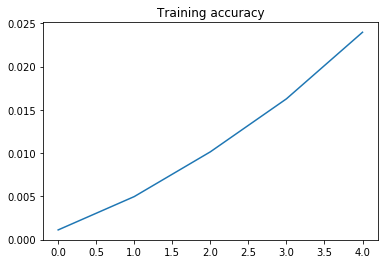

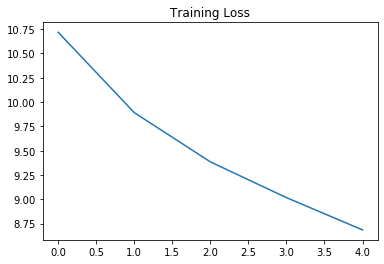

<Figure size 432x288 with 0 Axes>

In [5]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.title('Training Loss')
plt.figure()